In [760]:
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
# PyTorch related imports would go here
import numpy as np

In [761]:
from sklearn.feature_extraction.text import TfidfVectorizer
from us import states
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import re

In [762]:
state_names = [state.name.lower() for state in states.STATES]
state_abbrs = [state.abbr for state in states.STATES]
city_df = pd.read_csv('PM25-Speciated/worldcities.csv')
city_names = city_df['city_ascii'].str.lower().tolist()  # First column
country_names = city_df['country'].str.lower().tolist()  # First column

In [763]:
stop_words = TfidfVectorizer(stop_words='english').get_stop_words()
stop_words = list(list(stop_words)+ city_names + country_names + state_names + state_abbrs)

# Original Data

In [764]:
# #DATASET_NAME = "SpeciateV5.3_PM_AE6.csv"
# DATASET_NAME = "SpeciateV5.3_PM_All.csv"
# df = pd.read_csv('PM25-Speciated/specviate_v5_3datasets/'+DATASET_NAME, encoding='ISO-8859-1')

In [765]:
# DATASET_NAME = "PM_AE6_v5.3_v10182024.csv"
DATASET_NAME = "PM_ALL2.5um_v5.3_v10182024.csv"
df = pd.read_csv('PM25-Speciated/reviseddatasetwithtotalocandec/'+DATASET_NAME, encoding='ISO-8859-1')

In [766]:
df

,PROFILE_CODE,PROFILE_NAME,PROFILE_TYPE,CONTROLS,REGION,MASTER_POLLUTANT,TOTAL,LOWER_SIZE,UPPER_SIZE,QSCORE_DESC,...,CATEGORY_LEVEL_3_ Fuel_Product,CAS,SPECIES_NAME,WEIGHT_PERCENT,INCLUDE_IN_SUM,UNCERTAINTY_PERCENT,UNCERTAINTY_METHOD,SPEC_MW,SRS ID,Data_Origin
0,000002.5,Overall Composite,PM,Not Applicable,NaN,PM,63.098999,0,2.5,NaN,...,Miscellaneous,7440-62-2,Vanadium,0.0610,Yes,0.065000,NaN,50.941500,150193.0,NaN
1,000002.5,Overall Composite,PM,Not Applicable,NaN,PM,63.098999,0,2.5,NaN,...,Miscellaneous,7440-32-6,Titanium,0.1940,Yes,0.066000,NaN,47.867000,149930.0,NaN
2,000002.5,Overall Composite,PM,Not Applicable,NaN,PM,63.098999,0,2.5,NaN,...,Miscellaneous,7440-31-5,Tin,0.1170,Yes,0.041000,NaN,118.710000,149922.0,NaN
3,000002.5,Overall Composite,PM,Not Applicable,NaN,PM,63.098999,0,2.5,NaN,...,Miscellaneous,7704-34-9,Sulfur,2.9720,No,1.232000,NaN,32.060000,152744.0,NaN
4,000002.5,Overall Composite,PM,Not Applicable,NaN,PM,63.098999,0,2.5,NaN,...,Miscellaneous,14808-79-8,Sulfate,5.5140,Yes,3.198000,NaN,96.060000,197301.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40233,95780.0,Paved Road Dust,PM,NaN,"Lake Tahoe, Nevada",PM,55.612400,0,2.5,Excellent,...,Paved,14797-55-8,Nitrate,0.0000,Yes,0.123300,Standard,62.005000,197186.0,Literature
40234,95780.0,Paved Road Dust,PM,NaN,"Lake Tahoe, Nevada",PM,55.612400,0,2.5,Excellent,...,Paved,7439-97-6,Mercury,0.0000,Yes,0.009700,Standard,200.590000,149633.0,Literature
40235,95780.0,Paved Road Dust,PM,NaN,"Lake Tahoe, Nevada",PM,55.612400,0,2.5,Excellent,...,Paved,7440-09-7,Potassium,1.7946,No,0.191820,Standard,39.098300,149740.0,Literature
40236,95780.0,Paved Road Dust,PM,NaN,"Lake Tahoe, Nevada",PM,55.612400,0,2.5,Excellent,...,Paved,7439-95-4,Magnesium,0.1509,Yes,0.419457,Standard,24.305000,149617.0,Literature


In [767]:
df = df.pivot_table(index=['PROFILE_CODE', 'PROFILE_NAME'], columns='SPECIES_NAME', values='WEIGHT_PERCENT', aggfunc='first').reset_index()
# Fill NaN values with 0 (or any other value you prefer)
df = df.fillna(0)

In [768]:
df

SPECIES_NAME,PROFILE_CODE,PROFILE_NAME,Aluminum,Ammonium,Antimony,Arsenic,Bromine,Cadmium,Calcium,Calcium ion,...,Silicon,Sodium,Sodium ion,Sulfate,Sulfur,Tin,Titanium,Vanadium,Zinc,Zirconium
0,4928.0,Light Duty Vehicle Exhaust - Gasoline,0.009102,0.000000,0.000000,0.000000,0.001175,0.001860,0.084859,0.0,...,0.804542,0.000000,0.0,0.122247,0.163355,0.000294,0.000685,0.000000,0.130665,0.000000
1,4929.0,Light Duty Vehicle Exhaust - Gasoline,0.215623,0.411821,0.000000,0.000000,0.003885,0.000000,0.835297,0.0,...,4.355199,0.287498,0.0,1.670594,0.790618,0.000000,0.005828,0.000000,0.971275,0.003885
2,4930.0,Light Duty Vehicle Exhaust - Gasoline,0.182884,0.295805,0.763448,0.000000,0.003682,0.000000,7.161929,0.0,...,2.372581,0.000000,0.0,1.293689,0.421001,0.000000,0.000000,0.000000,1.548990,0.000000
3,4931.0,Light Duty Vehicle Exhaust - Gasoline,0.038245,0.090889,0.000000,0.000675,0.000900,0.004499,0.388077,0.0,...,1.339934,0.000000,0.0,0.398876,0.346907,0.000000,0.000000,0.000000,0.561081,0.000225
4,4932.0,Light Duty Vehicle Exhaust - Gasoline,0.016707,0.100999,0.083153,0.000000,0.000570,0.000000,0.757491,0.0,...,0.479745,0.000000,0.0,0.144094,0.100619,0.005031,0.000000,0.000000,0.209592,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,4924,Light Duty Vehicle Exhaust - Gasoline,0.062483,0.123429,0.000000,0.000000,0.002049,0.000000,0.924438,0.0,...,1.009455,0.000000,0.0,0.444550,0.368751,0.000000,0.000000,0.000000,0.943900,0.001024
1440,4925,Light Duty Vehicle Exhaust - Gasoline,0.074404,0.532148,0.000000,0.000000,0.006470,0.009705,0.650223,0.0,...,4.910638,0.218358,0.0,1.471897,0.729479,0.000000,0.006470,0.001617,0.579054,0.001617
1441,4926,Light Duty Vehicle Exhaust - Gasoline,0.093078,0.139374,0.015594,0.000000,0.003411,0.000000,0.157405,0.0,...,2.982893,0.000000,0.0,0.485372,0.309449,0.006822,0.009746,0.002924,0.325531,0.016082
1442,4927,Light Duty Vehicle Exhaust - Gasoline,0.021773,0.081707,0.000000,0.000000,0.000936,0.000000,0.207429,0.0,...,1.259558,0.000000,0.0,0.290541,0.341579,0.000000,0.000000,0.000000,0.266193,0.000000


In [769]:
def clean_text(text):
    # Remove numbers and special characters
    text = re.sub(r'[^A-Za-z\s]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [770]:
# df['name'] = df['name'].apply(clean_text)

In [771]:
df

SPECIES_NAME,PROFILE_CODE,PROFILE_NAME,Aluminum,Ammonium,Antimony,Arsenic,Bromine,Cadmium,Calcium,Calcium ion,...,Silicon,Sodium,Sodium ion,Sulfate,Sulfur,Tin,Titanium,Vanadium,Zinc,Zirconium
0,4928.0,Light Duty Vehicle Exhaust - Gasoline,0.009102,0.000000,0.000000,0.000000,0.001175,0.001860,0.084859,0.0,...,0.804542,0.000000,0.0,0.122247,0.163355,0.000294,0.000685,0.000000,0.130665,0.000000
1,4929.0,Light Duty Vehicle Exhaust - Gasoline,0.215623,0.411821,0.000000,0.000000,0.003885,0.000000,0.835297,0.0,...,4.355199,0.287498,0.0,1.670594,0.790618,0.000000,0.005828,0.000000,0.971275,0.003885
2,4930.0,Light Duty Vehicle Exhaust - Gasoline,0.182884,0.295805,0.763448,0.000000,0.003682,0.000000,7.161929,0.0,...,2.372581,0.000000,0.0,1.293689,0.421001,0.000000,0.000000,0.000000,1.548990,0.000000
3,4931.0,Light Duty Vehicle Exhaust - Gasoline,0.038245,0.090889,0.000000,0.000675,0.000900,0.004499,0.388077,0.0,...,1.339934,0.000000,0.0,0.398876,0.346907,0.000000,0.000000,0.000000,0.561081,0.000225
4,4932.0,Light Duty Vehicle Exhaust - Gasoline,0.016707,0.100999,0.083153,0.000000,0.000570,0.000000,0.757491,0.0,...,0.479745,0.000000,0.0,0.144094,0.100619,0.005031,0.000000,0.000000,0.209592,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,4924,Light Duty Vehicle Exhaust - Gasoline,0.062483,0.123429,0.000000,0.000000,0.002049,0.000000,0.924438,0.0,...,1.009455,0.000000,0.0,0.444550,0.368751,0.000000,0.000000,0.000000,0.943900,0.001024
1440,4925,Light Duty Vehicle Exhaust - Gasoline,0.074404,0.532148,0.000000,0.000000,0.006470,0.009705,0.650223,0.0,...,4.910638,0.218358,0.0,1.471897,0.729479,0.000000,0.006470,0.001617,0.579054,0.001617
1441,4926,Light Duty Vehicle Exhaust - Gasoline,0.093078,0.139374,0.015594,0.000000,0.003411,0.000000,0.157405,0.0,...,2.982893,0.000000,0.0,0.485372,0.309449,0.006822,0.009746,0.002924,0.325531,0.016082
1442,4927,Light Duty Vehicle Exhaust - Gasoline,0.021773,0.081707,0.000000,0.000000,0.000936,0.000000,0.207429,0.0,...,1.259558,0.000000,0.0,0.290541,0.341579,0.000000,0.000000,0.000000,0.266193,0.000000


In [772]:
# numeric_cols = df.select_dtypes(include=[np.number]).columns
# text_cols = df.select_dtypes(include=[object]).columns

# print(text_cols)

# agg_funcs = {col: 'mean' for col in numeric_cols}
# agg_funcs.update({col: lambda x: np.random.choice(x) for col in text_cols if col != 'name'})

# pivot_df = df.groupby('name').agg(agg_funcs).reset_index()

In [773]:
# cols = list(pivot_df.columns)
# cols.insert(0, cols.pop(cols.index('code')))
# pivot_df = pivot_df[cols]
# pivot_df

In [774]:
pivot_df = df
pivot_df

SPECIES_NAME,PROFILE_CODE,PROFILE_NAME,Aluminum,Ammonium,Antimony,Arsenic,Bromine,Cadmium,Calcium,Calcium ion,...,Silicon,Sodium,Sodium ion,Sulfate,Sulfur,Tin,Titanium,Vanadium,Zinc,Zirconium
0,4928.0,Light Duty Vehicle Exhaust - Gasoline,0.009102,0.000000,0.000000,0.000000,0.001175,0.001860,0.084859,0.0,...,0.804542,0.000000,0.0,0.122247,0.163355,0.000294,0.000685,0.000000,0.130665,0.000000
1,4929.0,Light Duty Vehicle Exhaust - Gasoline,0.215623,0.411821,0.000000,0.000000,0.003885,0.000000,0.835297,0.0,...,4.355199,0.287498,0.0,1.670594,0.790618,0.000000,0.005828,0.000000,0.971275,0.003885
2,4930.0,Light Duty Vehicle Exhaust - Gasoline,0.182884,0.295805,0.763448,0.000000,0.003682,0.000000,7.161929,0.0,...,2.372581,0.000000,0.0,1.293689,0.421001,0.000000,0.000000,0.000000,1.548990,0.000000
3,4931.0,Light Duty Vehicle Exhaust - Gasoline,0.038245,0.090889,0.000000,0.000675,0.000900,0.004499,0.388077,0.0,...,1.339934,0.000000,0.0,0.398876,0.346907,0.000000,0.000000,0.000000,0.561081,0.000225
4,4932.0,Light Duty Vehicle Exhaust - Gasoline,0.016707,0.100999,0.083153,0.000000,0.000570,0.000000,0.757491,0.0,...,0.479745,0.000000,0.0,0.144094,0.100619,0.005031,0.000000,0.000000,0.209592,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,4924,Light Duty Vehicle Exhaust - Gasoline,0.062483,0.123429,0.000000,0.000000,0.002049,0.000000,0.924438,0.0,...,1.009455,0.000000,0.0,0.444550,0.368751,0.000000,0.000000,0.000000,0.943900,0.001024
1440,4925,Light Duty Vehicle Exhaust - Gasoline,0.074404,0.532148,0.000000,0.000000,0.006470,0.009705,0.650223,0.0,...,4.910638,0.218358,0.0,1.471897,0.729479,0.000000,0.006470,0.001617,0.579054,0.001617
1441,4926,Light Duty Vehicle Exhaust - Gasoline,0.093078,0.139374,0.015594,0.000000,0.003411,0.000000,0.157405,0.0,...,2.982893,0.000000,0.0,0.485372,0.309449,0.006822,0.009746,0.002924,0.325531,0.016082
1442,4927,Light Duty Vehicle Exhaust - Gasoline,0.021773,0.081707,0.000000,0.000000,0.000936,0.000000,0.207429,0.0,...,1.259558,0.000000,0.0,0.290541,0.341579,0.000000,0.000000,0.000000,0.266193,0.000000


In [775]:
pivot_df.iloc[:,2:49].head()

SPECIES_NAME,Aluminum,Ammonium,Antimony,Arsenic,Bromine,Cadmium,Calcium,Calcium ion,Chloride ion,Chlorine,...,Silicon,Sodium,Sodium ion,Sulfate,Sulfur,Tin,Titanium,Vanadium,Zinc,Zirconium
0,0.009102,0.000000,0.000000,0.000000,0.001175,0.001860,0.084859,0.0,0.022316,0.0,...,0.804542,0.000000,0.0,0.122247,0.163355,0.000294,0.000685,0.0,0.130665,0.000000
1,0.215623,0.411821,0.000000,0.000000,0.003885,0.000000,0.835297,0.0,0.652697,0.0,...,4.355199,0.287498,0.0,1.670594,0.790618,0.000000,0.005828,0.0,0.971275,0.003885
2,0.182884,0.295805,0.763448,0.000000,0.003682,0.000000,7.161929,0.0,0.000000,0.0,...,2.372581,0.000000,0.0,1.293689,0.421001,0.000000,0.000000,0.0,1.548990,0.000000
3,0.038245,0.090889,0.000000,0.000675,0.000900,0.004499,0.388077,0.0,0.019798,0.0,...,1.339934,0.000000,0.0,0.398876,0.346907,0.000000,0.000000,0.0,0.561081,0.000225
4,0.016707,0.100999,0.083153,0.000000,0.000570,0.000000,0.757491,0.0,0.017466,0.0,...,0.479745,0.000000,0.0,0.144094,0.100619,0.005031,0.000000,0.0,0.209592,0.000000


# Clustering based on numeric values

In [776]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import Counter

In [777]:
def assign_cluster_name(cluster):
    names = pivot_df[pivot_df['speciated_cluster'] == cluster]['PROFILE_NAME']
    most_common_name = Counter(names).most_common(1)[0][0]
    return most_common_name

In [778]:
X = pivot_df.iloc[:, 2:49]
#scaler = StandardScaler()
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

In [779]:
X

SPECIES_NAME,Aluminum,Ammonium,Antimony,Arsenic,Bromine,Cadmium,Calcium,Calcium ion,Chloride ion,Chlorine,...,Silicon,Sodium,Sodium ion,Sulfate,Sulfur,Tin,Titanium,Vanadium,Zinc,Zirconium
0,0.009102,0.000000,0.000000,0.000000,0.001175,0.001860,0.084859,0.0,0.022316,0.0,...,0.804542,0.000000,0.0,0.122247,0.163355,0.000294,0.000685,0.000000,0.130665,0.000000
1,0.215623,0.411821,0.000000,0.000000,0.003885,0.000000,0.835297,0.0,0.652697,0.0,...,4.355199,0.287498,0.0,1.670594,0.790618,0.000000,0.005828,0.000000,0.971275,0.003885
2,0.182884,0.295805,0.763448,0.000000,0.003682,0.000000,7.161929,0.0,0.000000,0.0,...,2.372581,0.000000,0.0,1.293689,0.421001,0.000000,0.000000,0.000000,1.548990,0.000000
3,0.038245,0.090889,0.000000,0.000675,0.000900,0.004499,0.388077,0.0,0.019798,0.0,...,1.339934,0.000000,0.0,0.398876,0.346907,0.000000,0.000000,0.000000,0.561081,0.000225
4,0.016707,0.100999,0.083153,0.000000,0.000570,0.000000,0.757491,0.0,0.017466,0.0,...,0.479745,0.000000,0.0,0.144094,0.100619,0.005031,0.000000,0.000000,0.209592,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,0.062483,0.123429,0.000000,0.000000,0.002049,0.000000,0.924438,0.0,0.282709,0.0,...,1.009455,0.000000,0.0,0.444550,0.368751,0.000000,0.000000,0.000000,0.943900,0.001024
1440,0.074404,0.532148,0.000000,0.000000,0.006470,0.009705,0.650223,0.0,0.446422,0.0,...,4.910638,0.218358,0.0,1.471897,0.729479,0.000000,0.006470,0.001617,0.579054,0.001617
1441,0.093078,0.139374,0.015594,0.000000,0.003411,0.000000,0.157405,0.0,0.263641,0.0,...,2.982893,0.000000,0.0,0.485372,0.309449,0.006822,0.009746,0.002924,0.325531,0.016082
1442,0.021773,0.081707,0.000000,0.000000,0.000936,0.000000,0.207429,0.0,0.000000,0.0,...,1.259558,0.000000,0.0,0.290541,0.341579,0.000000,0.000000,0.000000,0.266193,0.000000


In [780]:
model = NMF(n_components=32, init='random', random_state=0, max_iter=1000)
W = model.fit_transform(X)
H = model.components_

# What features to use for clustering

In [781]:
# Assuming 'target' is the category column, and 'name' is the label
X = pivot_df.iloc[:, 2:49]
#X = W

# Hierarchical Clustering

## k-NN Graph Construction

In [782]:
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from scipy.sparse.linalg import svds

In [783]:
# Apply SVD to X
U, S, VT = svds(X.values, k=16)
X_svd = U @ np.diag(S) @ VT

In [784]:
X = X_svd

In [785]:
# Compute KNN

K = 15
knn = NearestNeighbors(n_neighbors=K)  # You can change the number of neighbors
knn.fit(X)
distances, indices = knn.kneighbors(X)

# Create a graph
G = nx.Graph()

# Add nodes with PROFILE_NAME as labels
for i, profile_name in enumerate(df['PROFILE_NAME']):
    G.add_node(i, label=profile_name)

# Add edges based on KNN
for i, neighbors in enumerate(indices):
    for neighbor in neighbors:
        if i != neighbor:  # Avoid self-loops
            G.add_edge(i, neighbor)

In [786]:
import matplotlib
matplotlib.use('Agg')  # Use a non-interactive backend

In [787]:
# pos = nx.spring_layout(G)  # Layout for visualization
# labels = nx.get_node_attributes(G, 'label')

# plt.figure(figsize=(50, 50))
# nx.draw(G, pos, with_labels=True, labels=labels, node_size=100, node_color='skyblue', font_size=10, font_color='black', edge_color='gray')
# plt.title('K-Nearest Neighbor Graph')
# plt.show()

# Community Dectection

In [788]:
import cdlib
from cdlib import algorithms
import networkx as nx
# G = nx.karate_club_graph()

# non-overlap louvain
coms = algorithms.louvain(G, weight='weight', resolution=1., randomize=False)

In [789]:
print(coms.method_name)
print(coms.communities)
print(coms.node_coverage)
print(coms.overlap )
print(coms.method_parameters)
#print(coms.to_json)
print(coms.average_internal_degree())
print(coms.average_internal_degree(summary=False))

Louvain
[[3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 21, 32, 53, 55, 62, 64, 66, 69, 70, 77, 78, 79, 88, 91, 94, 96, 239, 277, 280, 282, 283, 284, 285, 286, 288, 289, 290, 291, 293, 562, 563, 564, 565, 566, 567, 568, 569, 570, 699, 792, 793, 794, 795, 797, 798, 799, 800, 801, 802, 803, 808, 810, 811, 812, 813, 814, 815, 816, 817, 818, 820, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 857, 858, 859, 861, 862, 863, 1128, 1145, 1158, 1159, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1171, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1279, 1282, 1283, 1285, 1287, 1288, 1289, 1298, 1366, 1402, 1404, 1405, 1406, 1423, 1426, 1429, 1430, 1432, 1433, 1434, 1436, 1437, 1442], [37, 38, 101, 116, 117, 118, 119, 120, 121, 125, 130, 136, 139, 141, 151, 163, 164, 166, 184, 185, 193, 209, 231, 276, 279, 287, 296, 297, 300, 302, 303, 304, 311, 312,

In [790]:
com_map={}

for i in range(len(coms.communities)):
    community = coms.communities[i]
    for j in community:
        com_map[j] = i
        
com_map

{3: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 21: 0,
 32: 0,
 53: 0,
 55: 0,
 62: 0,
 64: 0,
 66: 0,
 69: 0,
 70: 0,
 77: 0,
 78: 0,
 79: 0,
 88: 0,
 91: 0,
 94: 0,
 96: 0,
 239: 0,
 277: 0,
 280: 0,
 282: 0,
 283: 0,
 284: 0,
 285: 0,
 286: 0,
 288: 0,
 289: 0,
 290: 0,
 291: 0,
 293: 0,
 562: 0,
 563: 0,
 564: 0,
 565: 0,
 566: 0,
 567: 0,
 568: 0,
 569: 0,
 570: 0,
 699: 0,
 792: 0,
 793: 0,
 794: 0,
 795: 0,
 797: 0,
 798: 0,
 799: 0,
 800: 0,
 801: 0,
 802: 0,
 803: 0,
 808: 0,
 810: 0,
 811: 0,
 812: 0,
 813: 0,
 814: 0,
 815: 0,
 816: 0,
 817: 0,
 818: 0,
 820: 0,
 823: 0,
 824: 0,
 825: 0,
 826: 0,
 827: 0,
 828: 0,
 829: 0,
 830: 0,
 831: 0,
 832: 0,
 833: 0,
 834: 0,
 846: 0,
 847: 0,
 848: 0,
 849: 0,
 850: 0,
 851: 0,
 852: 0,
 853: 0,
 854: 0,
 855: 0,
 857: 0,
 858: 0,
 859: 0,
 861: 0,
 862: 0,
 863: 0,
 1128: 0,
 1145: 0,
 1158: 0,
 1159: 0,
 1161: 0,
 1162: 0,
 1163: 0,
 1164: 0,
 1165: 0,
 1166: 0,
 1167: 0,
 1168: 0,
 1171: 0,
 11

In [791]:
coms_l = [algorithms.louvain(G), algorithms.label_propagation(G), algorithms.walktrap(G)]
overlap_coms = algorithms.endntm(G, coms_l)

In [792]:
print(overlap_coms.communities)

[[512, 514, 1052, 546, 547, 37, 38, 1069, 575, 576, 1097, 590, 591, 592, 595, 1113, 1115, 605, 101, 613, 115, 116, 117, 118, 119, 120, 121, 125, 130, 132, 136, 139, 651, 141, 653, 655, 151, 163, 164, 166, 167, 174, 1200, 1207, 184, 185, 703, 704, 193, 718, 719, 720, 209, 721, 722, 723, 725, 726, 727, 729, 730, 731, 732, 733, 231, 1295, 1296, 1297, 276, 279, 287, 1311, 1312, 1314, 296, 297, 300, 302, 303, 304, 306, 307, 308, 309, 311, 312, 1339, 1341, 318, 1342, 320, 321, 322, 323, 324, 325, 326, 329, 331, 335, 338, 341, 342, 343, 345, 346, 347, 348, 350, 351, 352, 354, 355, 868, 359, 360, 361, 362, 363, 364, 365, 367, 368, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 384, 385, 386, 897, 389, 390, 902, 903, 905, 907, 400, 402, 404, 407, 415, 416, 417, 418, 1443, 420, 427, 428, 430, 433, 434, 435, 437, 446, 451, 968, 460, 462, 469, 471, 473, 474, 475, 476, 477, 478, 479, 480, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 498, 509, 510, 511

In [793]:
overlap_com_map={}

for i in range(len(overlap_coms.communities)):
    community = overlap_coms.communities[i]
    for j in community:
        if j in overlap_com_map:
            overlap_com_map[j].append(i)
        else:
            overlap_com_map[j] = [i]
            
overlap_com_map

{512: [0],
 514: [0],
 1052: [0],
 546: [0],
 547: [0],
 37: [0],
 38: [0],
 1069: [0],
 575: [0, 8],
 576: [0],
 1097: [0],
 590: [0],
 591: [0],
 592: [0],
 595: [0],
 1113: [0],
 1115: [0],
 605: [0],
 101: [0],
 613: [0],
 115: [0, 8],
 116: [0],
 117: [0],
 118: [0],
 119: [0],
 120: [0],
 121: [0],
 125: [0],
 130: [0],
 132: [0, 8],
 136: [0],
 139: [0],
 651: [0],
 141: [0],
 653: [0],
 655: [0, 1],
 151: [0],
 163: [0],
 164: [0],
 166: [0],
 167: [0],
 174: [0],
 1200: [0],
 1207: [0, 11],
 184: [0],
 185: [0],
 703: [0],
 704: [0],
 193: [0],
 718: [0],
 719: [0, 8],
 720: [0],
 209: [0],
 721: [0],
 722: [0],
 723: [0],
 725: [0, 11],
 726: [0, 11],
 727: [0],
 729: [0],
 730: [0],
 731: [0],
 732: [0, 5],
 733: [0],
 231: [0],
 1295: [0],
 1296: [0],
 1297: [0, 8],
 276: [0],
 279: [0],
 287: [0],
 1311: [0],
 1312: [0],
 1314: [0],
 296: [0],
 297: [0],
 300: [0],
 302: [0],
 303: [0],
 304: [0],
 306: [0],
 307: [0, 11],
 308: [0],
 309: [0],
 311: [0],
 312: [0],
 1339:

In [794]:
for i in range(len(pivot_df)):
    if i not in overlap_com_map:
        print(i)

In [795]:
# nx.write_graphml(G, 'knn_graph.graphml')


labels=[]
# y = [i+'-'+j for i,j in zip(pivot_df['PROFILE_NAME'],pivot_df['PROFILE_CODE'])]
y = [str(i) for i in pivot_df['PROFILE_CODE']]
labels = dict(zip(range(len(y)), y))

print(labels)

overlap_com_map_str = {key: ",".join([str(i) for i in value]) for key, value in overlap_com_map.items()}

nx.set_node_attributes(G, labels, 'labels')
nx.set_node_attributes(G, com_map, 'non_overlap_community')
nx.set_node_attributes(G, overlap_com_map_str, 'overlap_community')

filename = DATASET_NAME+"KNN"+str(K)+'.gexf'
print("Writing gephi...."+filename)
nx.write_gexf(G, filename)
print("Done....")

{0: '4928.0', 1: '4929.0', 2: '4930.0', 3: '4931.0', 4: '4932.0', 5: '4933.0', 6: '4934.0', 7: '4935.0', 8: '4936.0', 9: '4937.0', 10: '4938.0', 11: '4939.0', 12: '4940.0', 13: '4941.0', 14: '4942.0', 15: '4972.0', 16: '4973.0', 17: '4974.0', 18: '4975.0', 19: '4976.0', 20: '4977.0', 21: '4978.0', 22: '4979.0', 23: '4980.0', 24: '4981.0', 25: '4982.0', 26: '4983.0', 27: '4984.0', 28: '4985.0', 29: '4986.0', 30: '4987.0', 31: '4988.0', 32: '4989.0', 33: '4990.0', 34: '4991.0', 35: '4992.0', 36: '4993.0', 37: '4994.0', 38: '4995.0', 39: '4996.0', 40: '4997.0', 41: '4998.0', 42: '4999.0', 43: '5000.0', 44: '5001.0', 45: '5002.0', 46: '5003.0', 47: '5004.0', 48: '5005.0', 49: '5006.0', 50: '5007.0', 51: '5566.0', 52: '5567.0', 53: '5568.0', 54: '5569.0', 55: '5570.0', 56: '5571.0', 57: '5572.0', 58: '5573.0', 59: '5574.0', 60: '5575.0', 61: '5576.0', 62: '5577.0', 63: '5578.0', 64: '5579.0', 65: '5580.0', 66: '5581.0', 67: '5582.0', 68: '5583.0', 69: '5584.0', 70: '5585.0', 71: '5586.0', 7

In [796]:
pivot_df.head()

SPECIES_NAME,PROFILE_CODE,PROFILE_NAME,Aluminum,Ammonium,Antimony,Arsenic,Bromine,Cadmium,Calcium,Calcium ion,...,Silicon,Sodium,Sodium ion,Sulfate,Sulfur,Tin,Titanium,Vanadium,Zinc,Zirconium
0,4928.0,Light Duty Vehicle Exhaust - Gasoline,0.009102,0.000000,0.000000,0.000000,0.001175,0.001860,0.084859,0.0,...,0.804542,0.000000,0.0,0.122247,0.163355,0.000294,0.000685,0.0,0.130665,0.000000
1,4929.0,Light Duty Vehicle Exhaust - Gasoline,0.215623,0.411821,0.000000,0.000000,0.003885,0.000000,0.835297,0.0,...,4.355199,0.287498,0.0,1.670594,0.790618,0.000000,0.005828,0.0,0.971275,0.003885
2,4930.0,Light Duty Vehicle Exhaust - Gasoline,0.182884,0.295805,0.763448,0.000000,0.003682,0.000000,7.161929,0.0,...,2.372581,0.000000,0.0,1.293689,0.421001,0.000000,0.000000,0.0,1.548990,0.000000
3,4931.0,Light Duty Vehicle Exhaust - Gasoline,0.038245,0.090889,0.000000,0.000675,0.000900,0.004499,0.388077,0.0,...,1.339934,0.000000,0.0,0.398876,0.346907,0.000000,0.000000,0.0,0.561081,0.000225
4,4932.0,Light Duty Vehicle Exhaust - Gasoline,0.016707,0.100999,0.083153,0.000000,0.000570,0.000000,0.757491,0.0,...,0.479745,0.000000,0.0,0.144094,0.100619,0.005031,0.000000,0.0,0.209592,0.000000


In [797]:
pivot_df.to_csv("ForSOM_"+DATASET_NAME, index=False)
print("DataFrame saved")

DataFrame saved


## Box Plot

In [798]:
import matplotlib.pyplot as plt

# This magic command ensures that plots are shown inline in Jupyter Notebook
%matplotlib inline

In [799]:
def find_row_number(pivot_df, input_value):
    if isinstance(input_value, int):
        # If the input is an integer, use it directly to access the row number
        return [input_value]
    else:
        # If the input is a string, search in PROFILE_NAME and PROFILE_CODE
        result = pivot_df[(pivot_df['PROFILE_NAME'].str.contains(input_value, case=False, na=False)) |
                          (pivot_df['PROFILE_CODE'].str.contains(input_value, case=False, na=False))]
        if not result.empty:
            return result.index.tolist()
        else:
            return None

# to find element either give profile code as "5674", profile name as "Residual Oil Combustion - Composite"
# or just integer row number from pivot_df

elems = find_row_number(pivot_df, "Forest Fire")
elems

[783, 784, 785, 786, 787, 913, 1315, 1316, 1317, 1318, 1319, 1320]

In [800]:
elem = elems[0]
cluster = next((cluster for cluster in coms.communities if elem in cluster), None)
selected_rows = pivot_df.loc[cluster]

selected_rows

SPECIES_NAME,PROFILE_CODE,PROFILE_NAME,Aluminum,Ammonium,Antimony,Arsenic,Bromine,Cadmium,Calcium,Calcium ion,...,Silicon,Sodium,Sodium ion,Sulfate,Sulfur,Tin,Titanium,Vanadium,Zinc,Zirconium
29,4986.0,Diesel Exhaust - Heavy-heavy duty truck - CARB...,1.390891,13.231810,0.000000,0.007215,0.009058,0.000000,1.857114,0.0,...,4.525708,2.474564,0.00,5.921428,1.702321,0.000000,0.255156,0.018838,0.141486,0.000000
30,4987.0,Diesel Exhaust - Heavy-heavy duty truck - CARB...,0.616180,13.231810,0.013738,0.025306,0.008034,0.051335,1.814317,0.0,...,3.518090,2.474564,0.00,5.921428,1.363148,0.013416,0.000000,0.000000,0.093351,0.006106
111,5675.0,Marine Vessel - Auxiliary Engine - Marine Gas Oil,0.000000,0.000000,0.061466,0.000000,0.000000,0.023641,1.912530,0.0,...,0.340426,0.000000,0.00,12.078014,0.000000,0.035461,0.014184,0.082742,0.200946,0.000000
113,5679.0,Diesel Exhaust - Heavy-heavy duty truck - 2007...,0.080222,0.000000,0.000889,0.000000,0.001000,0.000000,0.420333,0.0,...,0.055667,0.933111,0.00,39.666667,10.738667,0.000111,0.005111,0.000111,0.176444,0.000000
122,8873.0,Aircraft Exhaust,0.000000,1.791897,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.00,6.867400,3.128145,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1324,4643,Residential Wood Combustion,0.006000,0.450000,0.000000,0.000000,0.000000,0.002000,0.007000,0.0,...,0.011000,0.000000,0.18,0.240000,0.000000,0.000000,0.000000,0.000000,0.005000,0.000000
1333,4660,Cigarette Smoke,0.000000,0.030000,0.000000,0.000000,0.000000,0.020000,0.000000,0.0,...,0.000000,0.000000,0.03,0.070000,0.130000,0.010000,0.000000,0.000000,0.010000,0.000000
1334,4663,Industrial surface coating operations - water ...,1.130000,0.000000,1.420000,0.000000,0.000000,0.000000,0.980000,0.0,...,0.050000,0.000000,0.00,0.000000,0.000000,0.000000,12.500000,0.000000,0.000000,0.000000
1346,4736,Distillate Oil Combustion,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.00,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


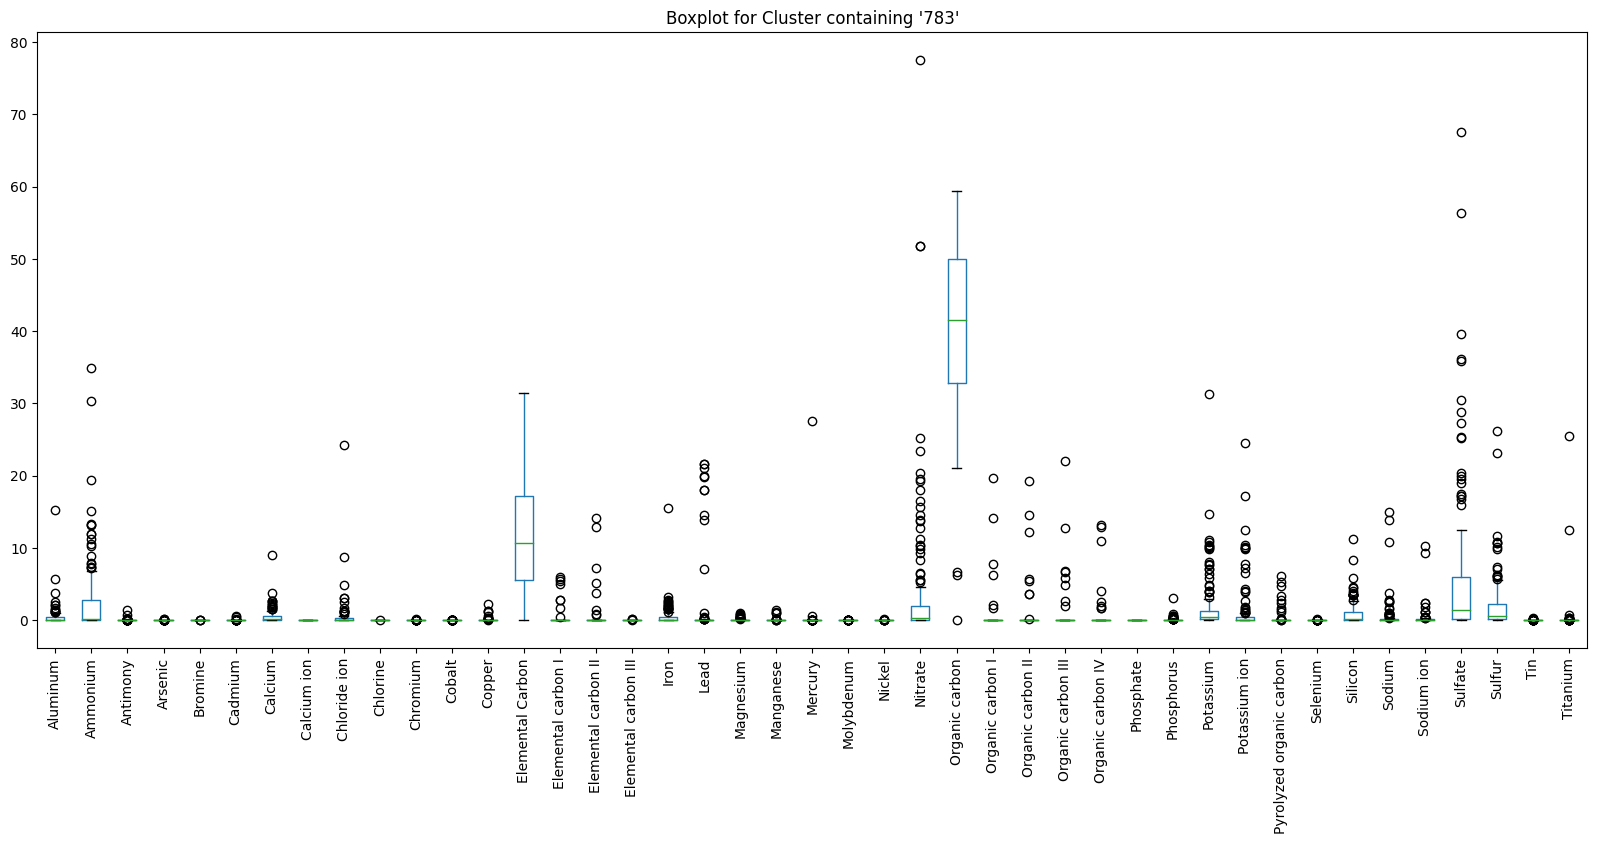

In [801]:
ax = selected_rows.iloc[:, 2:45].boxplot(figsize=(20, 8), grid=False)  # grid=False removes grid
ax.grid(False)

plt.title(f"Boxplot for Cluster containing '{elem}'")
plt.xticks(rotation=90)  # Rotate x-labels if needed
plt.show()

In [802]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD, NMF

Index(['Organic carbon', 'Sulfate', 'Nitrate', 'Nitrate', 'Potassium', 'Lead',
       'Ammonium', 'Ammonium', 'Titanium', 'Mercury'],
      dtype='object', name='SPECIES_NAME')


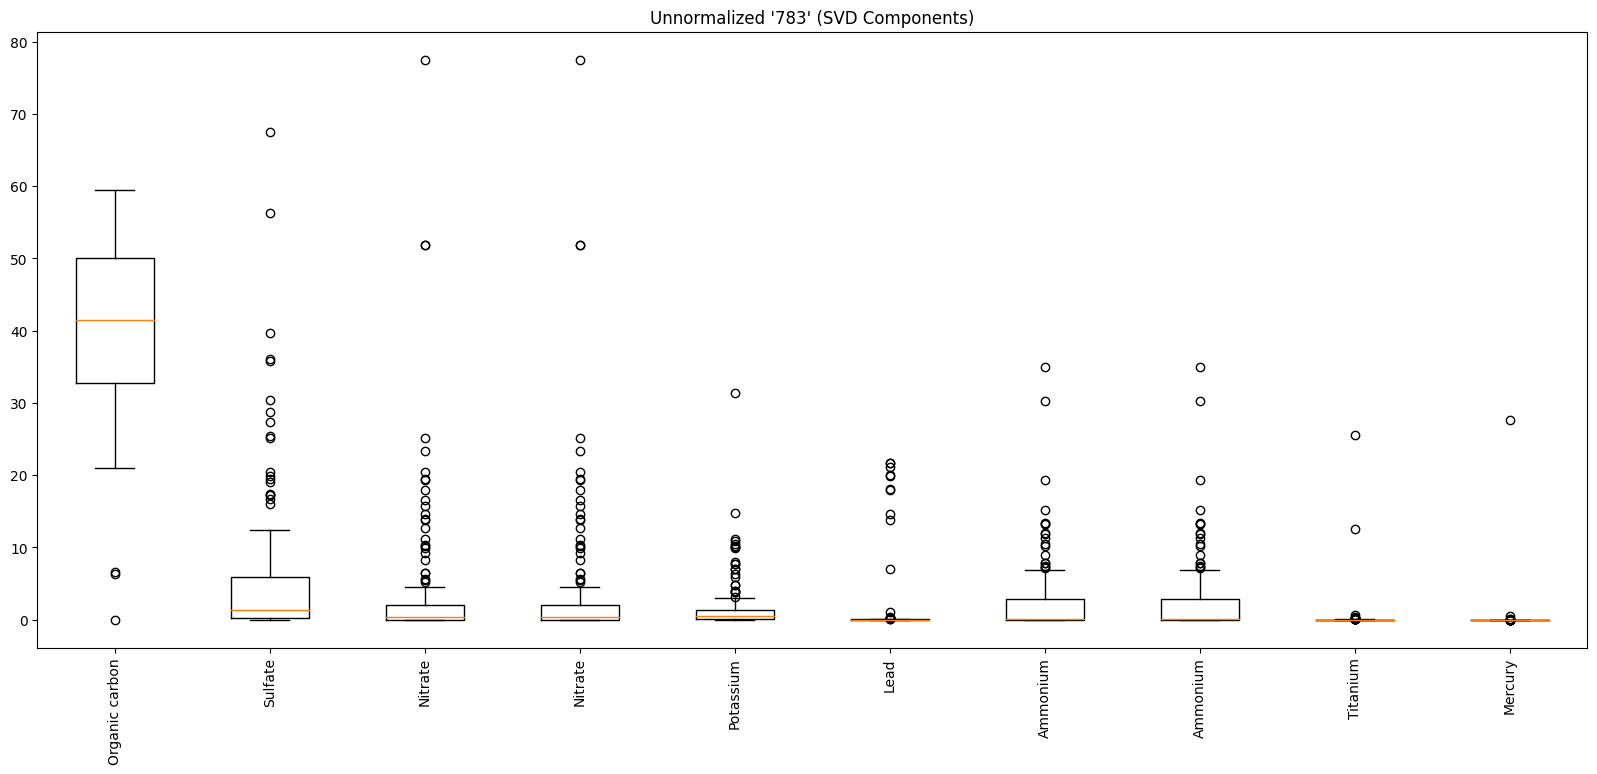

In [808]:
# # Normalize the values
# scaler = StandardScaler()
# normalized_data = scaler.fit_transform(selected_rows.iloc[:, 2:45])

# # Create the first box plot with normalized values
# fig, ax = plt.subplots(figsize=(20, 8))
# ax.boxplot(normalized_data)
# ax.grid(False)
# ax.set_xticklabels(selected_rows.columns[2:45], rotation=90)
# plt.title(f"Boxplot for Cluster containing '{elem}' (Normalized Values)")
# plt.xticks(rotation=90)
# plt.show()

# Use SVD to find important components
svd = TruncatedSVD(n_components=5)
svd_data = svd.fit_transform(selected_rows.iloc[:, 2:45])

# Get the most important columns based on SVD components
important_columns_svd = selected_rows.columns[2:45][svd.components_.argmax(axis=1)]
print(important_columns_svd)



# Create the second box plot with SVD components
fig, ax = plt.subplots(figsize=(20, 8))
# ax.boxplot(svd_data)
ax.boxplot(selected_rows[important_columns_svd])
ax.grid(False)
plt.title(f"Unnormalized '{elem}' (SVD Components)")
ax.set_xticklabels(important_columns_svd, rotation=90)
plt.show()


# # Create the second box plot with SVD components
# fig, ax = plt.subplots(figsize=(20, 8))
# scaler = StandardScaler()
# normalized_data = scaler.fit_transform(selected_rows[important_columns_svd])


# # ax.boxplot(svd_data)
# ax.boxplot(normalized_data)
# ax.grid(False)
# plt.title(f"Normalized'{elem}' (SVD Components)")
# ax.set_xticklabels(important_columns_svd, rotation=90)
# plt.show()

# # Use NMF to find important components
# nmf = NMF(n_components=5)
# nmf_data = nmf.fit_transform(selected_rows.iloc[:, 2:45])

# # Get the most important columns based on NMF components
# important_columns_nmf = selected_rows.columns[2:45][nmf.components_.argmax(axis=1)]

# # Create the third box plot with NMF components
# fig, ax = plt.subplots(figsize=(20, 8))
# ax.boxplot(nmf_data)
# ax.grid(False)
# plt.title(f"Boxplot for Cluster containing '{elem}' (NMF Components)")
# ax.set_xticklabels(important_columns_nmf, rotation=90)
# plt.show()


In [804]:
# # Initialize NMF and fit to the data
# model = NMF(n_components=2, init='random', random_state=0)
# W = model.fit_transform(X)
# H = model.components_

# # Visualize the data
# plt.scatter(W[:, 0], W[:, 1], c=y)
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.title('NMF Components')
# plt.colorbar()
# plt.show()

In [805]:
selected_rows.iloc[:,25]

29      0.009058
30      0.000884
111     0.026005
113     0.004667
122     0.000000
          ...   
1324    0.000000
1333    0.010000
1334    0.000000
1346    0.000000
1355    0.000000
Name: Nickel, Length: 144, dtype: float64